# Capstone Project - New Restaurant in Town

## Project by Erick Daniel Rodriguez

### 1. Introduction

Mexico city is one of the most populated cities around the world, the city is divided in sixteen main boroughs, using statistical government data from Mexico City (INEGI) and with the Foursquare API, this project will try to find which boroughs are similar according to the different venues located in each borough.

### 2. Data

#### 2.1 Data description

The data that will be used for this project will be:

* Number of restaurants within the area of each borough
    - Foursquare API


* Population and job occupation division of each borough
    - Statistics data from 2017 of Mexico City (https://www.datatur.sectur.gob.mx/ITxEF_Docs/CDMX_ANUARIO_PDF.pdf)


* Borough coordinates
    - Open StreetMap (https://www.openstreetmap.org/relation/1376330)

#### 2.2 Data preparation

The first step will be to import the libraries that will be used.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import tabula as tb # library for PDF to DataFrame conversion

import pandas as pd # library for data analsysis

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import folium # map rendering library

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests # library to handle requests

print('Libraries imported.')

Libraries imported.


Creat dataframes from the "Statistics data from 2017 of Mexico City" report using the library Tabula.

In [2]:
file_path = "https://www.datatur.sectur.gob.mx/ITxEF_Docs/CDMX_ANUARIO_PDF.pdf"
#Convert the file
occupation = tb.read_pdf(file_path, pages=331)

We have downloaded the employed population by delegation and its percentage distribution according to occupational division by March 15th of 2015 from the report, now we will look at the data and make the relevant adjustments.

In [3]:
occupation=occupation[0] # Here we will index it to 0
occupation

,Unnamed: 0,Total,Unnamed: 1,División ocupacional a/,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,(Porcentaje),NaN,NaN
1,Delegación,NaN,"Funcionarios,",Trabajadores Trabajadores,Comerciantes y,No
2,NaN,NaN,"profesionistas,",agropecuarios en la industria c/,trabajadores en,especificado
3,NaN,NaN,técnicos y,NaN,servicios diversos d/,NaN
4,NaN,NaN,administrativos b/,NaN,NaN,NaN
5,Ciudad de México,4 033 273,43.91,0.39 14.63,39.44,1.62
6,Álvaro Obregón,351 409,42.30,0.14 16.55,39.34,1.66
7,Azcapotzalco,180 813,48.17,0.02 14.19,35.99,1.63
8,Benito Juárez,223 843,69.81,0.01 5.02,24.04,1.12
9,Coyoacán,280 561,54.74,0.04 10.44,32.04,2.74


We can notice there is a problem with the first few rows of the dataframe, therefore, these first rows will be deleted and new ones will be added also considering new titles.

In [4]:
occupation.drop(occupation.head(6).index,inplace=True)
occupation

,Unnamed: 0,Total,Unnamed: 1,División ocupacional a/,Unnamed: 2,Unnamed: 3
6,Álvaro Obregón,351 409,42.30,0.14 16.55,39.34,1.66
7,Azcapotzalco,180 813,48.17,0.02 14.19,35.99,1.63
8,Benito Juárez,223 843,69.81,0.01 5.02,24.04,1.12
9,Coyoacán,280 561,54.74,0.04 10.44,32.04,2.74
10,Cuajimalpa de Morelos,91 063,41.60,0.26 16.85,39.82,1.46
11,Cuauhtémoc,269 664,51.26,0.06 8.13,38.54,2.02
12,Gustavo A. Madero,498 501,40.56,0.10 16.79,41.49,1.06
13,Iztacalco,175 194,46.45,0.15 14.20,38.10,1.09
14,Iztapalapa,786 218,34.80,0.10 18.50,45.30,1.31
15,La Magdalena Contreras,105 951,35.87,0.23 17.55,43.50,2.86


In [5]:
occupation.columns = ['Borough', 'Total', '%A', '%B', '%C', '%D']
occupation

,Borough,Total,%A,%B,%C,%D
6,Álvaro Obregón,351 409,42.30,0.14 16.55,39.34,1.66
7,Azcapotzalco,180 813,48.17,0.02 14.19,35.99,1.63
8,Benito Juárez,223 843,69.81,0.01 5.02,24.04,1.12
9,Coyoacán,280 561,54.74,0.04 10.44,32.04,2.74
10,Cuajimalpa de Morelos,91 063,41.60,0.26 16.85,39.82,1.46
11,Cuauhtémoc,269 664,51.26,0.06 8.13,38.54,2.02
12,Gustavo A. Madero,498 501,40.56,0.10 16.79,41.49,1.06
13,Iztacalco,175 194,46.45,0.15 14.20,38.10,1.09
14,Iztapalapa,786 218,34.80,0.10 18.50,45.30,1.31
15,La Magdalena Contreras,105 951,35.87,0.23 17.55,43.50,2.86


There is a problem with column "%B", the column is displaying two values, therefore, this must be changed in order to have two different columns.

In [6]:
nums1, nums2 = list(), list()
for vals in occupation['%B'].values:
    nums = [float(i) for i in vals.split()]
    nums1.append(nums[0])
    nums2.append(nums[1])

occupation['%B'] = nums1
occupation['%B2'] = nums2 # Temporary name for the splitted of the column
occupation

,Borough,Total,%A,%B,%C,%D,%B2
6,Álvaro Obregón,351 409,42.30,0.14,39.34,1.66,16.55
7,Azcapotzalco,180 813,48.17,0.02,35.99,1.63,14.19
8,Benito Juárez,223 843,69.81,0.01,24.04,1.12,5.02
9,Coyoacán,280 561,54.74,0.04,32.04,2.74,10.44
10,Cuajimalpa de Morelos,91 063,41.60,0.26,39.82,1.46,16.85
11,Cuauhtémoc,269 664,51.26,0.06,38.54,2.02,8.13
12,Gustavo A. Madero,498 501,40.56,0.10,41.49,1.06,16.79
13,Iztacalco,175 194,46.45,0.15,38.10,1.09,14.20
14,Iztapalapa,786 218,34.80,0.10,45.30,1.31,18.50
15,La Magdalena Contreras,105 951,35.87,0.23,43.50,2.86,17.55


The column is now correctly splitted, however, the column was sent to the end of the dataframe, so we have to place it in the correct order.

In [7]:
occupation=occupation[['Borough', 'Total', '%A', '%B', '%B2','%C', '%D']]
occupation.columns = ['Borough', 'Total', '%A', '%B', '%C', '%D', '%E']
occupation.style.set_caption("Employed population by delegation and its percentage distribution according to occupational division")
occupation

,Borough,Total,%A,%B,%C,%D,%E
6,Álvaro Obregón,351 409,42.30,0.14,16.55,39.34,1.66
7,Azcapotzalco,180 813,48.17,0.02,14.19,35.99,1.63
8,Benito Juárez,223 843,69.81,0.01,5.02,24.04,1.12
9,Coyoacán,280 561,54.74,0.04,10.44,32.04,2.74
10,Cuajimalpa de Morelos,91 063,41.60,0.26,16.85,39.82,1.46
11,Cuauhtémoc,269 664,51.26,0.06,8.13,38.54,2.02
12,Gustavo A. Madero,498 501,40.56,0.10,16.79,41.49,1.06
13,Iztacalco,175 194,46.45,0.15,14.20,38.10,1.09
14,Iztapalapa,786 218,34.80,0.10,18.50,45.30,1.31
15,La Magdalena Contreras,105 951,35.87,0.23,17.55,43.50,2.86


We now have the correct order. The dataframe is divided by borough.
The meaning of each column is the following:
* Borough = Name of the borough

* Total = Total population

* %A = officers, directors and managers; professionals and technicians; as well as auxiliary workers in administrative activities.

* %B = Agricultural workers.

* %C = Craft workers; as well as industrial machinery operators, assemblers, drivers and transport drivers.

* %D = Merchants, sales employees, and sales agents; workers in personal services and surveillance; as well as workers in elementary and support activities.

* %E = Not specified


Now we will get the latitude and longitude of the neighbourhoods, which are retrieved using Open Street Map Geocoding

In [8]:
#Get Latitude and Longitude for suburbs
address= occupation['Borough']
geolocater= Nominatim(user_agent="mexico_city-explorer")
location=[]
empty=[]

def getcoords(add):
    try:
        coords= geolocater.geocode(add, timeout=10)
        location.append([add, coords.latitude, coords.longitude])
        print("the coords are {}".format(location[-1]))
    
    except GeocoderTimedOut:
        return getcoords(add)
    
    except:
        empty.append([add])
        print("Couldn't find coords of {}".format(empty[-1]))
        
for add in address:
        getcoords(add)

the coords are ['Álvaro Obregón', 19.318148049999998, -99.2778443631872]
the coords are ['Azcapotzalco', 19.4858148, -99.18420573027606]
the coords are ['Benito Juárez', 20.8169666, -98.17826806649418]
the coords are ['Coyoacán', 19.32804005, -99.15106340693589]
the coords are ['Cuajimalpa de Morelos', 19.3187067, -99.32320297716439]
the coords are ['Cuauhtémoc', 19.4416128, -99.1518637]
the coords are ['Gustavo A. Madero', 19.518545449999998, -99.1436399464875]
the coords are ['Iztacalco', 19.39897535, -99.09531197032297]
the coords are ['Iztapalapa', 19.3428293, -99.04689193846701]
the coords are ['La Magdalena Contreras', 19.27547005, -99.26333858358939]
the coords are ['Miguel Hidalgo', 19.429614049999998, -99.19863845640572]
the coords are ['Milpa Alta', 19.138028, -99.05892017210884]
the coords are ['Tláhuac', 19.26950425, -99.00409684032508]
the coords are ['Tlalpan', 19.200877, -99.21701240427146]
the coords are ['Venustiano Carranza', 16.30898425, -92.6379347298267]
the coords

Now we trasnform the obtained borough latitude and longitude values into a dataframe.

In [9]:
CDMX=pd.DataFrame(location, columns=['Borough','Latitude','Longitude'])
CDMX

,Borough,Latitude,Longitude
0,Álvaro Obregón,19.318148,-99.277844
1,Azcapotzalco,19.485815,-99.184206
2,Benito Juárez,20.816967,-98.178268
3,Coyoacán,19.328040,-99.151063
4,Cuajimalpa de Morelos,19.318707,-99.323203
5,Cuauhtémoc,19.441613,-99.151864
6,Gustavo A. Madero,19.518545,-99.143640
7,Iztacalco,19.398975,-99.095312
8,Iztapalapa,19.342829,-99.046892
9,La Magdalena Contreras,19.275470,-99.263339


We can also obtain the latitude and longitude of Mexico City as a whole

In [10]:
address = 'Mexico City'

geolocator = Nominatim(user_agent="mexico_city-explorer")
location = geolocator.geocode(address)
latitude_CDMX = location.latitude
longitude_CDMX = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(latitude_CDMX, longitude_CDMX))

The geograpical coordinate of Mexico City are 19.4326296, -99.1331785.


We now create a map of Mexico City in order to see the division by each borough, this is created with the library folium. An important consideration is that some names on the labels will have an odd format, this is due to the fact that some borough names have accents. 

In [11]:
# Creates map of Mexico City using latitude and longitude values
map_CDMX = folium.Map(location=[latitude_CDMX, longitude_CDMX], zoom_start=10)

# Add markers to map
for lat, lng, borough in zip(CDMX['Latitude'], CDMX['Longitude'], CDMX['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CDMX)  
    
map_CDMX

Map looks great, however there are two locations which are incorrectly placed (Not in Mexico City) therefore, I will correct this by adding a string to the borough name, this way Open Street Map will know exactly the boroughs we need.

In [12]:
#Get Latitude and Longitude for suburbs
address= occupation['Borough'].astype(str) + ', Mexico City' # Added string to help API know exact location
geolocater= Nominatim(user_agent="mexico_city-explorer")
location=[]
empty=[]

def getcoords(add):
    try:
        coords= geolocater.geocode(add, timeout=10)
        location.append([add, coords.latitude, coords.longitude])
        print("the coords are {}".format(location[-1]))
    
    except GeocoderTimedOut:
        return getcoords(add)
    
    except:
        empty.append([add])
        print("Couldn't find coords of {}".format(empty[-1]))
        
for add in address:
        getcoords(add)

the coords are ['Álvaro Obregón, Mexico City', 19.318148049999998, -99.2778443631872]
the coords are ['Azcapotzalco, Mexico City', 19.4858148, -99.18420573027606]
the coords are ['Benito Juárez, Mexico City', 19.3804695, -99.1632429340113]
the coords are ['Coyoacán, Mexico City', 19.32804005, -99.15106340693589]
the coords are ['Cuajimalpa de Morelos, Mexico City', 19.3187067, -99.32320297716439]
the coords are ['Cuauhtémoc, Mexico City', 19.4326296, -99.1331785]
the coords are ['Gustavo A. Madero, Mexico City', 19.518545449999998, -99.1436399464875]
the coords are ['Iztacalco, Mexico City', 19.39897535, -99.09531197032297]
the coords are ['Iztapalapa, Mexico City', 19.3428293, -99.04689193846701]
the coords are ['La Magdalena Contreras, Mexico City', 19.27547005, -99.26333858358939]
the coords are ['Miguel Hidalgo, Mexico City', 19.429614049999998, -99.19863845640572]
the coords are ['Milpa Alta, Mexico City', 19.138028, -99.05892017210884]
the coords are ['Tláhuac, Mexico City', 19.2

In [13]:
CDMX_new=pd.DataFrame(location, columns=['Borough','Latitude','Longitude'])
CDMX_new

,Borough,Latitude,Longitude
0,"Álvaro Obregón, Mexico City",19.318148,-99.277844
1,"Azcapotzalco, Mexico City",19.485815,-99.184206
2,"Benito Juárez, Mexico City",19.380470,-99.163243
3,"Coyoacán, Mexico City",19.328040,-99.151063
4,"Cuajimalpa de Morelos, Mexico City",19.318707,-99.323203
5,"Cuauhtémoc, Mexico City",19.432630,-99.133178
6,"Gustavo A. Madero, Mexico City",19.518545,-99.143640
7,"Iztacalco, Mexico City",19.398975,-99.095312
8,"Iztapalapa, Mexico City",19.342829,-99.046892
9,"La Magdalena Contreras, Mexico City",19.275470,-99.263339


In [14]:
# Creates map of Mexico City using latitude and longitude values
map_CDMX_new = folium.Map(location=[latitude_CDMX, longitude_CDMX], zoom_start=10)

# Add markers to map
for lat, lng, borough in zip(CDMX_new['Latitude'], CDMX_new['Longitude'], CDMX_new['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CDMX_new)  
    
map_CDMX_new

All locations are now placed correctly. This ends the first section of the capstone project, on the next part we will begin to use the Foursquare API in order to start the clustering analysis.

### 3. Exploring Mexico City's Boroughs 

The first thing we need to set is the Foursquare API credentials and version

In [15]:
CLIENT_ID = 'WBF3HABTS4VOJEDTJQ4F1C2SXJMHGQUD3DWCTE2YJ0IIRSJS' # your Foursquare ID
CLIENT_SECRET = 'A0TYKKKNKYLJC2FHAP3KDOYU0EZ02BLRAFPRUUONZFHGVLOF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WBF3HABTS4VOJEDTJQ4F1C2SXJMHGQUD3DWCTE2YJ0IIRSJS
CLIENT_SECRET:A0TYKKKNKYLJC2FHAP3KDOYU0EZ02BLRAFPRUUONZFHGVLOF


Define a function which will return the venues from the Foursquare API of the different boroughs given the coordinates from the previous dataframe.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now that the function is defined, we can search for venues for each borough.

In [17]:
LIMIT = 100
radius = 5000
CDMX_venues = getNearbyVenues(names=CDMX_new['Borough'],
                                   latitudes=CDMX_new['Latitude'],
                                   longitudes=CDMX_new['Longitude'],
                                   radius = radius
                                  )

Álvaro Obregón, Mexico City
Azcapotzalco, Mexico City
Benito Juárez, Mexico City
Coyoacán, Mexico City
Cuajimalpa de Morelos, Mexico City
Cuauhtémoc, Mexico City
Gustavo A. Madero, Mexico City
Iztacalco, Mexico City
Iztapalapa, Mexico City
La Magdalena Contreras, Mexico City
Miguel Hidalgo, Mexico City
Milpa Alta, Mexico City
Tláhuac, Mexico City
Tlalpan, Mexico City
Venustiano Carranza, Mexico City
Xochimilco, Mexico City


Here we can see how many venues were returned from our function

In [18]:
print('{} venues were returned by Foursquare.'.format(CDMX_venues.shape[0]))
print('There are {} uniques categories.'.format(len(CDMX_venues['Venue Category'].unique())))

1384 venues were returned by Foursquare.
There are 228 uniques categories.


Interesting, now we can take a look at some of the data.

In [19]:
CDMX_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Álvaro Obregón, Mexico City",19.318148,-99.277844,Club Ecuestre San Francisco,19.327934,-99.259696,Farm
1,"Álvaro Obregón, Mexico City",19.318148,-99.277844,Café del Bosque,19.327297,-99.279234,Café
2,"Álvaro Obregón, Mexico City",19.318148,-99.277844,Mexitaco,19.320944,-99.263044,Taco Place
3,"Álvaro Obregón, Mexico City",19.318148,-99.277844,Parque Nacional Desierto de los Leones,19.322098,-99.308918,Park
4,"Álvaro Obregón, Mexico City",19.318148,-99.277844,Vista Al Bosque,19.339868,-99.266400,Golf Driving Range


Latitude and longitude data from each borough will be constantly repeating through this dataframe, since we already know those values, we can drop them.

In [20]:
CDMX_venues=CDMX_venues.drop(['Borough Latitude', 'Borough Longitude'], axis=1)
CDMX_venues

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Álvaro Obregón, Mexico City",Club Ecuestre San Francisco,19.327934,-99.259696,Farm
1,"Álvaro Obregón, Mexico City",Café del Bosque,19.327297,-99.279234,Café
2,"Álvaro Obregón, Mexico City",Mexitaco,19.320944,-99.263044,Taco Place
3,"Álvaro Obregón, Mexico City",Parque Nacional Desierto de los Leones,19.322098,-99.308918,Park
4,"Álvaro Obregón, Mexico City",Vista Al Bosque,19.339868,-99.266400,Golf Driving Range
...,...,...,...,...,...
1379,"Xochimilco, Mexico City","Café ""La Espalda De Dios""",19.261851,-99.098765,Snack Place
1380,"Xochimilco, Mexico City",Oxxo,19.249399,-99.057915,Convenience Store
1381,"Xochimilco, Mexico City",oxxo,19.246790,-99.083033,Department Store
1382,"Xochimilco, Mexico City",micheladas bravas,19.247730,-99.056815,Brewery


This new data frame looks sharper.

Now we can take a look at how many venue categories there are, since the data will be repeating for each column (latitude, longitude and venue), it will be created a new data frame just to make it more appealing.

In [21]:
CDMX_venues_count=CDMX_venues.drop(['Venue', 'Venue Latitude', 'Venue Longitude'], axis=1).groupby('Borough').count()
CDMX_venues_count

,Venue Category
Borough,
"Azcapotzalco, Mexico City",100
"Benito Juárez, Mexico City",100
"Coyoacán, Mexico City",100
"Cuajimalpa de Morelos, Mexico City",58
"Cuauhtémoc, Mexico City",100
"Gustavo A. Madero, Mexico City",100
"Iztacalco, Mexico City",100
"Iztapalapa, Mexico City",100
"La Magdalena Contreras, Mexico City",100


There are only three boroughs with few venues, let's see now what kind of categories are on each zone.

We apply one hot encoding, this will help the ML algorithm to know which are existants.

In [22]:
# One hot encoding
CDMX_onehot = pd.get_dummies(CDMX_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
CDMX_onehot['Borough'] = CDMX_venues['Borough'] 

# Move neighborhood column to the first column
fixed_columns = [CDMX_onehot.columns[-1]] + CDMX_onehot.columns[:-1].values.tolist()
CDMX_onehot = CDMX_onehot[fixed_columns]

CDMX_onehot.head()

,Borough,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Travel Lounge,University,Vegetarian / Vegan Restaurant,Veterinarian,Vineyard,Water Park,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Álvaro Obregón, Mexico City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Álvaro Obregón, Mexico City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Álvaro Obregón, Mexico City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Álvaro Obregón, Mexico City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Álvaro Obregón, Mexico City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group them by borough and reset the index just in case.

In [23]:
CDMX_grouped = CDMX_onehot.groupby('Borough').mean().reset_index()
CDMX_grouped.head()

,Borough,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Travel Lounge,University,Vegetarian / Vegan Restaurant,Veterinarian,Vineyard,Water Park,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Azcapotzalco, Mexico City",0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.00,0.00,...,0.0,0.00,0.00,0.01,0.000000,0.00,0.0,0.01,0.00,0.00
1,"Benito Juárez, Mexico City",0.0,0.0,0.0,0.00,0.0,0.00,0.02,0.02,0.00,...,0.0,0.01,0.01,0.00,0.000000,0.01,0.0,0.00,0.00,0.03
2,"Coyoacán, Mexico City",0.0,0.0,0.0,0.00,0.0,0.01,0.01,0.02,0.00,...,0.0,0.01,0.00,0.00,0.000000,0.00,0.0,0.00,0.00,0.00
3,"Cuajimalpa de Morelos, Mexico City",0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.017241,0.00,0.0,0.00,0.00,0.00
4,"Cuauhtémoc, Mexico City",0.0,0.0,0.0,0.02,0.0,0.00,0.04,0.07,0.02,...,0.0,0.00,0.02,0.00,0.000000,0.00,0.0,0.00,0.01,0.01


Next, we will define a function in order to get the most common venues (by category) for each borough.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's apply the previous function to all the boroughs.

In [25]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = CDMX_grouped['Borough']

for ind in np.arange(CDMX_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CDMX_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.apply(np.roll, shift=1)

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Álvaro Obregón, Mexico City",Mexican Restaurant,Park,Ice Cream Shop,Seafood Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Taco Place,Mountain,Bakery
1,"Azcapotzalco, Mexico City",Mexican Restaurant,Taco Place,Ice Cream Shop,Bakery,Coffee Shop,Breakfast Spot,Pharmacy,Food Truck,Cupcake Shop,Gym / Fitness Center
2,"Benito Juárez, Mexico City",Ice Cream Shop,Mexican Restaurant,Coffee Shop,Food Truck,Japanese Restaurant,Taco Place,Yoga Studio,Health & Beauty Service,Café,Pet Store
3,"Coyoacán, Mexico City",Ice Cream Shop,Mexican Restaurant,Bakery,Burger Joint,Coffee Shop,Breakfast Spot,Taco Place,Performing Arts Venue,Plaza,Clothing Store
4,"Cuajimalpa de Morelos, Mexico City",Mexican Restaurant,Park,Restaurant,Trail,Mountain,Dessert Shop,Taco Place,Historic Site,Burger Joint,Outdoors & Recreation
5,"Cuauhtémoc, Mexico City",Mexican Restaurant,Art Museum,Bakery,Theater,Ice Cream Shop,Hotel,Art Gallery,Plaza,Taco Place,History Museum
6,"Gustavo A. Madero, Mexico City",Mexican Restaurant,Taco Place,Burger Joint,Coffee Shop,Ice Cream Shop,Café,Restaurant,Spanish Restaurant,Clothing Store,Pizza Place
7,"Iztacalco, Mexico City",Taco Place,Mexican Restaurant,Restaurant,Bakery,Music Venue,Coffee Shop,Racetrack,Gym / Fitness Center,Stadium,Burger Joint
8,"Iztapalapa, Mexico City",Taco Place,Mexican Restaurant,Bakery,Breakfast Spot,Burger Joint,Seafood Restaurant,BBQ Joint,Restaurant,Fast Food Restaurant,Food Truck
9,"La Magdalena Contreras, Mexico City",Taco Place,Mexican Restaurant,Gym / Fitness Center,Ice Cream Shop,Seafood Restaurant,Coffee Shop,Café,Food Truck,Farm,Mountain


Run k-means to cluster the city into 5 clusters.

In [26]:
# set number of clusters
kclusters = 5

CDMX_grouped_clustering = CDMX_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(CDMX_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 3, 0, 1, 1, 1, 1, 0], dtype=int32)

Now there will be a new dataframe that includes the cluster as well as the top 10 venues for each borough.

### 4. Results and conclusions

In [27]:
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
CDMX_merged=CDMX_new
CDMX_merged=CDMX_merged.merge(boroughs_venues_sorted, on = 'Borough')

CDMX_merged

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Álvaro Obregón, Mexico City",19.318148,-99.277844,0,Mexican Restaurant,Park,Ice Cream Shop,Seafood Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Taco Place,Mountain,Bakery
1,"Azcapotzalco, Mexico City",19.485815,-99.184206,1,Mexican Restaurant,Taco Place,Ice Cream Shop,Bakery,Coffee Shop,Breakfast Spot,Pharmacy,Food Truck,Cupcake Shop,Gym / Fitness Center
2,"Benito Juárez, Mexico City",19.380470,-99.163243,0,Ice Cream Shop,Mexican Restaurant,Coffee Shop,Food Truck,Japanese Restaurant,Taco Place,Yoga Studio,Health & Beauty Service,Café,Pet Store
3,"Coyoacán, Mexico City",19.328040,-99.151063,0,Ice Cream Shop,Mexican Restaurant,Bakery,Burger Joint,Coffee Shop,Breakfast Spot,Taco Place,Performing Arts Venue,Plaza,Clothing Store
4,"Cuajimalpa de Morelos, Mexico City",19.318707,-99.323203,3,Mexican Restaurant,Park,Restaurant,Trail,Mountain,Dessert Shop,Taco Place,Historic Site,Burger Joint,Outdoors & Recreation
5,"Cuauhtémoc, Mexico City",19.432630,-99.133178,0,Mexican Restaurant,Art Museum,Bakery,Theater,Ice Cream Shop,Hotel,Art Gallery,Plaza,Taco Place,History Museum
6,"Gustavo A. Madero, Mexico City",19.518545,-99.143640,1,Mexican Restaurant,Taco Place,Burger Joint,Coffee Shop,Ice Cream Shop,Café,Restaurant,Spanish Restaurant,Clothing Store,Pizza Place
7,"Iztacalco, Mexico City",19.398975,-99.095312,1,Taco Place,Mexican Restaurant,Restaurant,Bakery,Music Venue,Coffee Shop,Racetrack,Gym / Fitness Center,Stadium,Burger Joint
8,"Iztapalapa, Mexico City",19.342829,-99.046892,1,Taco Place,Mexican Restaurant,Bakery,Breakfast Spot,Burger Joint,Seafood Restaurant,BBQ Joint,Restaurant,Fast Food Restaurant,Food Truck
9,"La Magdalena Contreras, Mexico City",19.275470,-99.263339,1,Taco Place,Mexican Restaurant,Gym / Fitness Center,Ice Cream Shop,Seafood Restaurant,Coffee Shop,Café,Food Truck,Farm,Mountain


Now let's see how our clusters look in the map.

In [28]:
# create map
map_clusters = folium.Map(location=[latitude_CDMX, longitude_CDMX], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CDMX_merged['Latitude'], CDMX_merged['Longitude'], CDMX_merged['Borough'], CDMX_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

If we look at the map we can notice the five different clusters, however, three of them are alone, clearly outliers, which makes sense since this boroughs are on the outskirts of town, as we recall, these where the boroughs that had the least venues (not at least 100, which was our maximum). Aside from that we can notice that there is not a clear division between "Cluster 0" and "Cluster 1". Let's try to find out why. 

To give equal importance to all features, we need to scale the continuous features.

In [29]:
mms = MinMaxScaler()
mms.fit(CDMX_onehot.drop(['Borough'], axis=1))
data_transformed = mms.transform(CDMX_onehot.drop(['Borough'], axis=1))

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [30]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

Below is a plot of sum of squared distances for k in the range specified above.

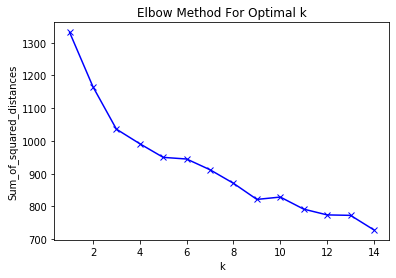

In [31]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As we can see, there is not a clear "arm" so we can not find the "elbow" to determine how many number of clusters would be ideal, this could mean that even just one cluster could fit our dataframe, which is not ideal for the scope of this project, however it is an interesting project result, one reason could be that many of the venues are taco places or mexican restaurants for all the different boroughs.

Let's now create a dataframe only for Taco Places and Mexican Restaurants.

In [32]:
CDMX_Taco_Places = CDMX_venues[(CDMX_venues['Venue Category'].str.contains('Taco Place', regex=False))].groupby(['Borough']).count()
CDMX_Mexican_Restaurant = CDMX_venues[(CDMX_venues['Venue Category'].str.contains('Mexican Restaurant', regex=False))].groupby(['Borough']).count()

CDMX_Mexican_Restaurant.drop(['Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
CDMX_Taco_Places.drop(['Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)

CDMX_Mexican_Restaurant.rename(columns = {'Venue Category':'Number of Mexican Restaurants'}, inplace=True)
CDMX_Taco_Places.rename(columns = {'Venue Category':'Number of Taco Places'}, inplace=True)

In [33]:
Mexican_food=CDMX_Mexican_Restaurant.merge(CDMX_Taco_Places, on = 'Borough')
Mexican_food['Total'] = Mexican_food.sum(axis=1)
Mexican_food

,Number of Mexican Restaurants,Number of Taco Places,Total
Borough,,,
"Azcapotzalco, Mexico City",25,12,37
"Benito Juárez, Mexico City",8,4,12
"Coyoacán, Mexico City",6,3,9
"Cuajimalpa de Morelos, Mexico City",17,2,19
"Cuauhtémoc, Mexico City",10,4,14
"Gustavo A. Madero, Mexico City",18,14,32
"Iztacalco, Mexico City",12,20,32
"Iztapalapa, Mexico City",17,20,37
"La Magdalena Contreras, Mexico City",13,19,32


As we recall:

In [34]:
print('There are {} uniques venue categories.'.format(len(CDMX_venues['Venue Category'].unique())))

There are 228 uniques venue categories.


And in many of the boroughs, just 2 venue categories accounted for close to 30% of the venues, as someone who lives in Mexico, not surprised that the most common category venue for each borough is a Mexican Restaurant or a Taco Place, we do enjoy our food!

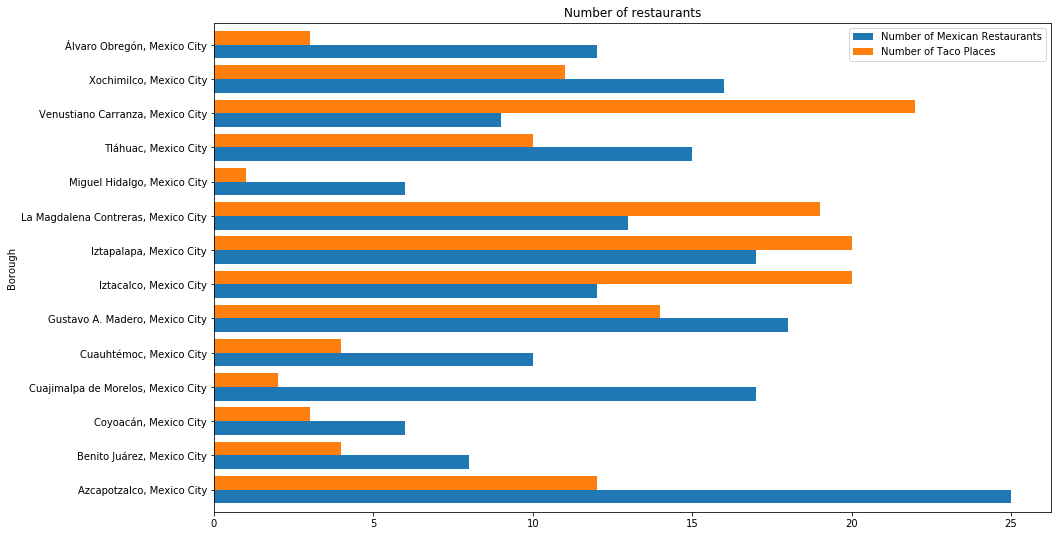

In [35]:
Mexican_food[['Number of Mexican Restaurants', 'Number of Taco Places']].plot(kind='barh', figsize=(15, 9), width = 0.8)
plt.ylabel('Borough') 
plt.title('Number of restaurants')
plt.show()